# Exporatory Analysis
Bino Maiheu

Version where i include the hotel pos/neg scores instead of removing them

In [1]:
# Importing packages
import numpy as np  # for matrix and data manipulation
import pandas as pd  # for DataFrames
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for more plotitng
import statsmodels.api as sm  # for statistical modelling
import scikitplot as skplt  # for scikit-learn plotting

from sklearn.preprocessing import StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import KFold, StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.svm import SVC  # SVM for classification
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

In [2]:
# Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Jupyter magic command to show plots inline immediately
%matplotlib inline

In [4]:
# Setting seed
seed = 43
np.random.seed(seed)

In [5]:
# Loading the house price dataset
data_file_path = './'  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

# Training data
train_V2 = pd.read_csv(data_file_path + 'train_V2.csv')
score = pd.read_csv(data_file_path + 'score.csv')
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

#dictionary = pd.read_csv(data_file_path + 'dictionary.csv')
#print('Dictionary set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
for col in train_V2.columns.tolist():
    print(col)

income_am
profit_last_am
profit_am
damage_am
damage_inc
crd_lim_rec
credit_use_ic
gluten_ic
lactose_ic
insurance_ic
spa_ic
empl_ic
cab_requests
married_cd
bar_no
sport_ic
neighbor_income
age
marketing_permit
urban_ic
dining_ic
presidential
client_segment
sect_empl
prev_stay
prev_all_in_stay
divorce
fam_adult_size
children_no
tenure_mts
tenure_yrs
company_ic
claims_no
claims_am
nights_booked
gender
shop_am
shop_use
retired
gold_status
score1_pos
score1_neg
score2_pos
score2_neg
score3_pos
score3_neg
score4_pos
score4_neg
score5_pos
score5_neg
outcome_profit
outcome_damage_inc
outcome_damage_amount


In [7]:
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

The score set doesn't containt the following target variables, the rest consider as input

In [8]:
set(train_V2.columns).difference(set(score.columns))

{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

All te variables seem to be numeric, except for the  `gender` : contains 'M' or 'V', replace by numeric value

In [9]:
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

Set an Id as index

In [10]:
# Setting 'Id' columns as index
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

## Missing values

Perform a missing values analysis, we check both dimensions, getting the number of missing rows per feature and getting the number of missing features per row. 

In [11]:
# First, get the number of missing rows per feature
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
missing_rows.head(50)

score2_pos          3791
score4_pos          3777
score1_pos          3775
score5_pos          3768
score3_pos          3739
score2_neg          3696
score1_neg          3686
score4_neg          3676
score3_neg          3633
score5_neg          3507
tenure_yrs           392
tenure_mts           392
neighbor_income      239
shop_use              88
presidential          88
cab_requests          88
dining_ic             88
company_ic            53
claims_no             53
income_am             53
gold_status           53
nights_booked         53
gender                53
shop_am               53
retired               53
fam_adult_size        53
children_no           53
divorce               53
profit_last_am        53
sport_ic              53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
lactose_ic            53
insurance_ic          53
prev_all_in_stay      53
profit_am             53
bar_no                53
age                   53
marketing_permit      53


In [12]:
# get the number of missing features per row
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False)  # total missng values, sorted
missing_features.head(100)  # Show top 20 most missing features

Id
306     48
2348    48
1744    48
3377    48
3068    48
2672    48
996     48
4641    48
4545    48
2058    47
4614    47
2096    47
4477    47
1062    47
4789    47
790     47
2250    47
670     47
2696    47
474     47
3793    47
90      47
3959    47
1696    47
4242    47
2734    47
1275    47
4851    47
1261    47
4392    47
1852    47
3952    47
4159    47
517     47
4138    47
3990    47
4946    47
4000    47
4993    47
1448    47
3213    47
2917    47
1281    46
4009    46
3494    46
2956    46
4669    46
1164    46
3926    46
3326    46
1338    46
4528    46
3198    46
2504    17
2895    16
863     16
4286    16
7       16
1267    15
781     15
1021    15
3166    15
4548    15
3606    15
1557    15
3192    15
3564    15
3149    15
3142    14
2387    14
4642    14
4644    14
3474    14
3330    14
4940    14
3727    14
3170    14
301     13
1782    13
845     13
473     13
3845    13
627     13
3167    13
507     12
3124    12
1900    12
1379    12
4389    12
1396    12
3015   

Conclusions :
- For the vast majority, the score*_pos, score*_neg values, are missing, probably best to disregard alltogether in the training ? 
- 53 members have a lot of missing values, probably best delete those rows alltogeher !
- The rest we can perhaps try to fill up using an Imputer

In [13]:
# drop the rows, we already dropped 10 columns, so be careful here... , better way to code this up
drop_rows = train_V2[train_V2.isnull().sum(axis=1) > 40 ].index

In [14]:
train_V2.drop(index=drop_rows, inplace=True)

In [15]:
train_V2.shape

(4947, 53)

So after this initial cleanup we are left with 7 features for which a given number of rows are missing and 

In [16]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


score2_pos         3738
score4_pos         3724
score1_pos         3722
score5_pos         3715
score3_pos         3686
score2_neg         3643
score1_neg         3633
score4_neg         3623
score3_neg         3580
score5_neg         3454
tenure_mts          339
tenure_yrs          339
neighbor_income     186
cab_requests         35
shop_use             35
dining_ic            35
presidential         35
dtype: int64

In [17]:
score_features = ["score1_pos", "score1_neg", "score2_pos", "score2_neg", "score3_pos", "score3_neg", "score4_pos", "score4_neg", "score5_pos", "score5_neg"]

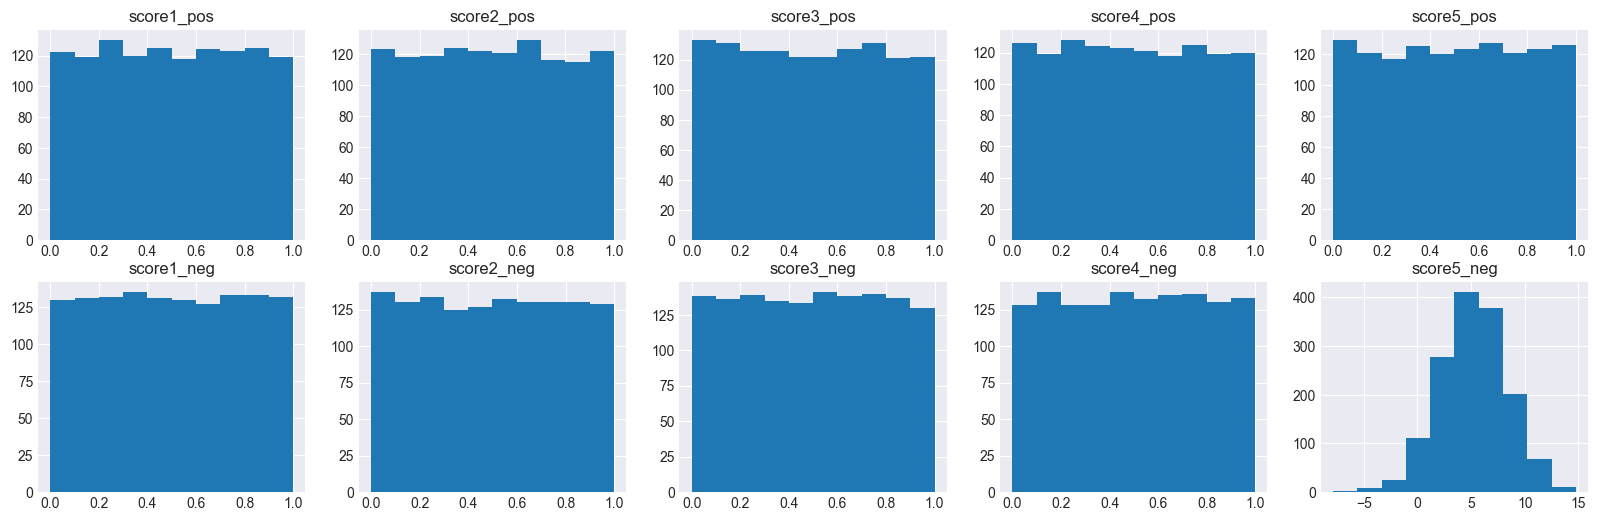

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

In [21]:
import scipy.stats as stats

train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

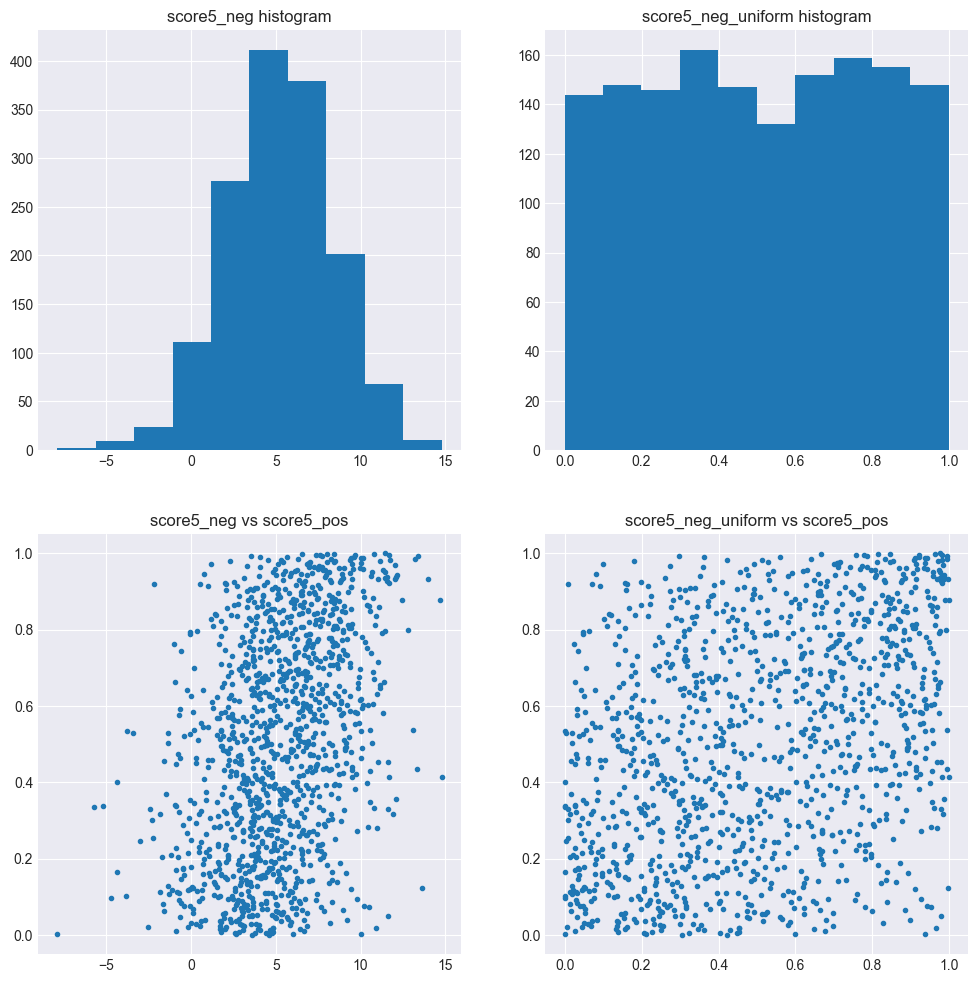

In [67]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [68]:
train_V2["score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg_uniform"]].mean(axis=1)

Text(0.5, 1.0, 'score_pos')

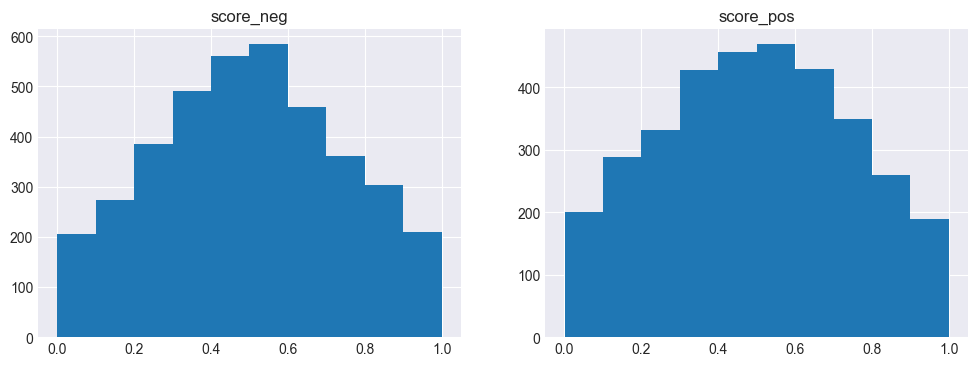

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["score_neg"].hist(ax=axs[0])
train_V2["score_pos"].hist(ax=axs[1])
axs[0].set_title("score_neg")
axs[1].set_title("score_pos")


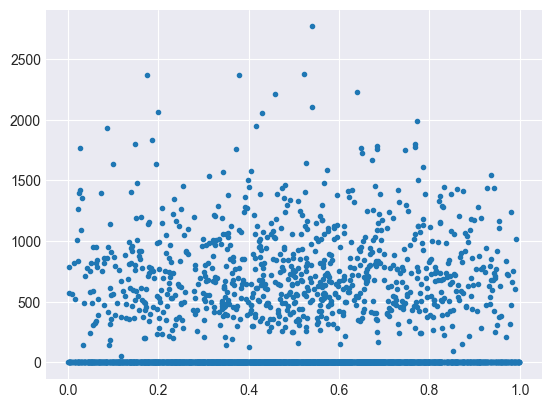

In [78]:
plt.plot(train_V2["score_pos"], train_V2["outcome_damage_amount"],'.')

In [85]:
train_V2["score_neg"].isna().sum()

1113

<Axes: >

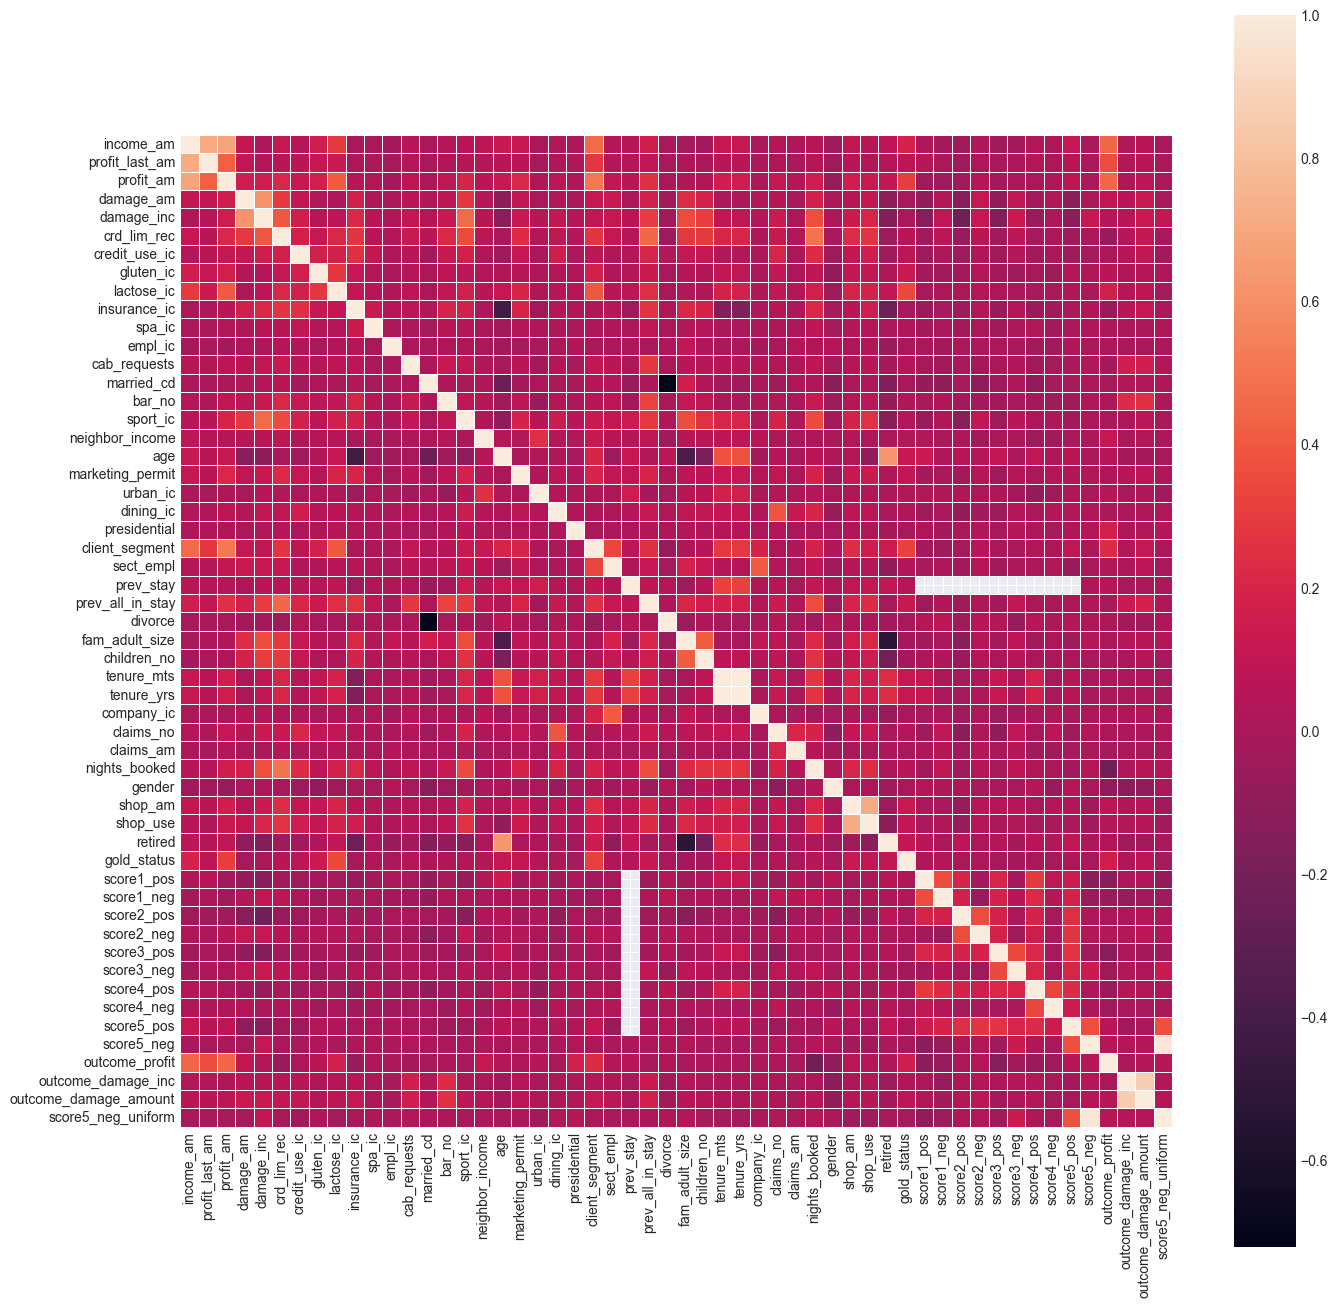

In [22]:
corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
plt.figure(figsize=(16, 16))
sns.heatmap(corrmat, vmax=1, square=True, linewidth=.5)

In [ ]:
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False)  # total missng values, sorted
print("These are the rows which contain missing features : ")
row_idx_missing = missing_features[missing_features>0]
print(row_idx_missing)

Let's examine those features a bit more closely to see how we can best recuperate them, let's try to use a little more advanced imputer than simply a mean or a most frequent and try a KNNImputer ;) It is shown on other datasets that the MSE via a RandomForestRegressor performs better using KNNImputer than using a Simple or Iterative (Multivariate) Imputer. See: https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py 


**Question**: how to deal with the scaling in case of the KNNImputer ? Should we rescale the features before & then scale back ? Probably, add as TODO !!

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

In [ ]:
missing_feats = missing_rows[missing_rows>0].index.to_list()
print("Feature with missing values : ")
print(missing_feats)

In [ ]:
# decide what categorical & continous variables are
{ col_name: train_V2[col_name].unique().shape[0] for col_name in train_V2[missing_feats].columns }

So, the ones with 3 distinc values : 0, 1 and NaN should be considered as categorical, the others as "continuous"

In [ ]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'tenure_yrs', 'neighbor_income', 'cab_requests']

In [ ]:
# get all the missing features, with SimpleImputer we have to select between continuous & categorical features
# probably here as well, for now we're just using the uniform weights, but check afterwards if the categorical
# values are ok
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform').set_output(transform="pandas")

train_V2 = imputer_knn.fit_transform(X=train_V2)

In [ ]:
# we print the unique values in the replaces values for the categorial features: 
for feat_name in missing_feats_categorical:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2.loc[row_idx_missing.index, feat_name].unique())

In [ ]:
# ha! so we have one little bastard slipping through, let's correct !
train_V2.loc[train_V2['dining_ic'] < 0.5,'dining_ic'] = 0.

Now finally test whether we still have missing values

In [ ]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

train_V2.isnull().sum().sum()

Ok, seems like we managed to get rid of all the missing values

## Outlier analysis

Now we have a complete train_V2 dataframe, let's check for outliers and unrealistic values

In [ ]:
n_features = len(train_V2.columns)

In [ ]:
n_features

In [ ]:

fig, axs = plt.subplots(5, 10, figsize=(20,12))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // 10
    col = idx % 10
    train_V2.boxplot([feat_name], ax=axs[row][col])

In [ ]:
train_V2.loc[train_V2['income_am']>300000,:]

This also seems to be the one guest with the highest profit_last & outcome_profit. Hmm, could be very rich person, so keeping this datapoint in, the rest actually seems ok. 

Conclusions

- don't think there are very many outliers actually present in the data, the one periode with very high income is definitely an outlier, however, it does not seem unrealistic, so keeping it in ? 

### Other data checks

- is the outcome_damage_amount consistent with outcome_damage_inc ?

In [ ]:
print(f"Max damage amount when no damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 0, 'outcome_damage_amount'].max()}")
print(f"Min damage amount when damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 1, 'outcome_damage_amount'].min()}")

Ha, so there are cases for which there is damage incurred, but the amount of the damage is 0 ... interesting

- What is the relation between `tenure_mts` and `tenure_yrs` ?

In [ ]:
sns.scatterplot(data=train_V2, x='tenure_mts', y='tenure_yrs')

Probably it makes no sense to include both, let's keep `tenure_mts` then...

In [ ]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)

## Correlation analysis

In [ ]:
corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
plt.figure(figsize=(16, 16))
sns.heatmap(corrmat, vmax=1, square=True, linewidth=.5)

## Model training

### Training / test set splitting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
target_features = [ "outcome_profit", "outcome_damage_inc", "outcome_damage_amount"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_profit"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

### Gradient Booster Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GradientBoostingRegressor().get_params()

In [ ]:
params = {'n_estimators': 500, 
          'max_depth': 4, 
          'min_samples_split': 2,
          'learning_rate': 0.01}

gbm = GradientBoostingRegressor(loss='squared_error',
                                 random_state=seed,
                                 **params) 

gbm.fit(X=X_train, y=y_train) 

# Step 4 - Getting predictions
gbm_preds = gbm.predict(X=X_test)

# Print R2 results
print('Train R2: %.3f' % gbm.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm.score(X=X_test, y=y_test))

In [ ]:
plt.plot(gbm_preds, y_test, '.')

**QUESTION** : perform a log-transform on the output value ? Looks like there are some outliers which may be dominating ? 

In [ ]:
np.logspace(start=-3, stop=-1, num=50)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# AMOUNT OF HYPERPARAMETERS TO SAMPLE
n_hyperparam_sample = 100

# Define possible hyperparameters you want to tune and the values they should be checked at
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=50)]
learning_rate = [x for x in np.logspace(start=-3, stop=-1, num=50)]  # THIS ONE IS NEW (AND IMPORTANT!) :)
max_features = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]

# Putting them all in a dictionary
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'subsample': subsample}

#min_impurity_decrease: 0.0,
# Instantiate base model to tune (RF with default settings, altough you can fix parameters here if you want)
gbr = GradientBoostingRegressor()

# Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=gbr, 
                                                 param_distributions=random_grid, 
                                                 n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                 cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                 verbose=2, # to print some outputs
                                                 random_state=seed, 
                                                 n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {rf_hyperparam_tuning_random.best_params_}")

In [ ]:
rf_hyperparam_tuning_random.best_params_

In [ ]:
rf_random_best = rf_hyperparam_tuning_random.best_estimator_

# Fitting the model
rf_random_best.fit(X=X_train, y=y_train)

print('Train R2: %.3f' % rf_random_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_random_best.score(X=X_test, y=y_test))

### Analyse the hyperparameter space to zoom in & then do a grid search

Strange ! The fit is worse on the test dataset after the optimization ???

In [ ]:
gbm_cv_results = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

In [ ]:
# Sorting and focusing on important cols only (AND SORTING!)
cv_res_important_cols = [x for x in gbm_cv_results.columns if 'param' in x] + ['mean_test_score', 'std_test_score', 'rank_test_score']
gbm_cv_results[cv_res_important_cols].sort_values(by='rank_test_score', ascending=True).head(5)

In [ ]:
for param in [ f"param_{key}" for key in random_grid.keys()]:
    plt.figure(); # This will make sure it's on different plots!
    plt.scatter(x=gbm_cv_results[param], y=gbm_cv_results['mean_test_score'], alpha=0.7);
    plt.title(f"{param} vs. CV R2");
    plt.xlabel(param);
    plt.ylabel('CV R2');

TODO: From this, define a better grid search ?!

In [ ]:
from sklearn.model_selection import GridSearchCV

learning_rate = [x for x in np.logspace(start=-2.5, stop=-0.5, num=30)]  # THIS ONE IS NEW (AND IMPORTANT!) :)
max_features = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.5, 0.55, 0.6, 0.65, 0.7]

# add pruning ? 


# A bit higher n_estimators
n_estimators =  [int(x) for x in np.linspace(start=100, stop=1000, num=50)] # take the same space as random search

# Some more reasonable learning rates
learning_rate = [0.015, 0.03, 0.05] 

# Max depth: not too deep
max_depth = [3, 4, 5]

# Subsample: intermediate
subsample = [0.5, 0.6]

# max_features: set slightly below 1 for little bit of regularization
max_features = [0.9]

# min_sample_leaf and min_samples_split
min_samples_leaf = [2]
min_samples_split = [2]

# total combinations:
total_combs = len(n_estimators) * len(learning_rate) * len(max_depth) * len(min_samples_leaf) * len(min_samples_split) * len(subsample) * len(max_features)
print(f"Amount of combinations: {total_combs}")

hyperparam_grid_focused = {'n_estimators': n_estimators,
                           'learning_rate': learning_rate,
                           'max_features': max_features,
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'subsample': subsample}

## Explainability

Is probably important for the executive summary, so better add some analysis and report the most important variables. 